# Backtesting Correlated Quantities
<div style="text-align: right">Nikolai Nowaczyk, Vladimir Piterbarg</div>

In backtesting we frequently encounter situations in which the samples are not independent due to e.g. overlapping horizons. There are various strategies to deal with these correlations, in particular i) filtering, ii) working the correlations into the null distributions via Monte Carlo and (iii) decorrelating the samples before applying a standard hypothesis test. In this notebook we illustrate how decorrelation avoids long-tailed null distributions and improves the discriminatory power of the test. More background on this can be found in the publications listed below.

In [1]:
%matplotlib widget
import numpy as np
import scipy.stats as ss
import matplotlib.pyplot as plt
from functools import partial
from scipy.stats import norm
import matplotlib.ticker as mtick

# Samples

## Daily returns
Assume we have $n:=250$ daily independent returns $Y_i$, which we assume to be jointly Gaussian, centered and of some volatility $\sigma$, i.e.
\begin{align*}
    Y_i \sim \mathcal{N}(0,\sigma^2), && i=1, \ldots, n=250.
\end{align*}

In [2]:
n = 250  # number of daily independent samples
sigma = 115  # this arbitrary volatility is used to create one sample of synthetic market data and would usually not be known

np.random.seed(1)
y_mkt = np.random.normal(0, sigma, n)

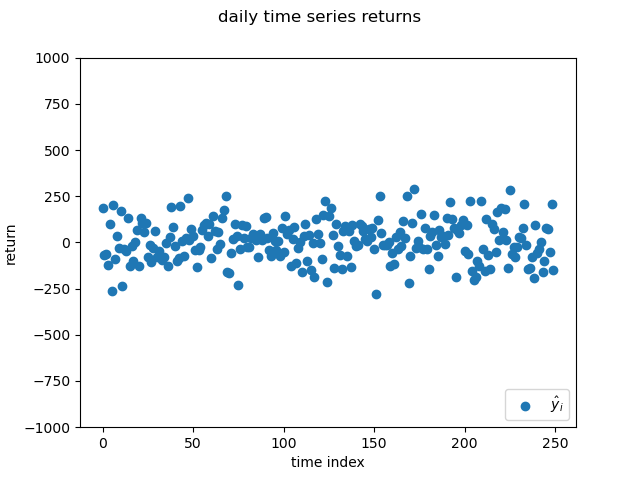

In [3]:
plt.figure()
plt.suptitle('daily time series returns')
plt.scatter(np.arange(n), y_mkt, label='$\\hat y_i$')
plt.xlabel('time index')
plt.ylabel('return')
plt.gca().set_ylim([-1000,1000])
plt.legend(loc='lower right')
plt.show()

## 10-day returns
Assume we are actually interested in the $m:=10$-day returns $X_i$ of that same quantity. These are given by
\begin{align*}
    X_i := \sum_{j=i}^{i+m-1}{Y_j} \sim \mathcal{N}(0, m \sigma^2), && i=1, \ldots, n_m := 241.
\end{align*}
These are also Gaussian and identically distributed, but for $m>1$ no longer independent. Denoting by $Y \in \mathbb{R}^n$ the vector of daily returns and by $X \in \mathbb{R}^{n_m}$ the vector of $m$-day returns, this relationship can also expressed by
\begin{align*}
    X = AY,
\end{align*}
where $A \in \mathbb{R}^{n_m \times n}$ is defined by
\begin{align*}
    A_{ij} := \begin{cases}
        1, & i \leq j \leq i+m-1, \\
        0, & \text{otherwise}
    \end{cases}.
\end{align*}

In [4]:
m = 10
n_m = n - m + 1
A = np.array([[1 if i <= j and j <= i + m - 1 else 0  
               for j in range(n)] 
             for i in range(n_m)])
x_mkt = A @ y_mkt

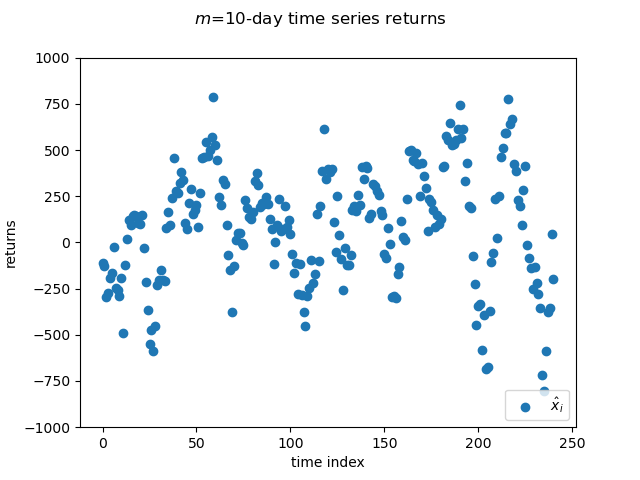

In [5]:
plt.figure()
plt.suptitle('$m$=10-day time series returns')
plt.scatter(np.arange(n_m), x_mkt, label='$\\hat x_i$')
plt.xlabel('time index')
plt.ylabel('returns')
plt.legend(loc='lower right')
plt.gca().set_ylim([-1000,1000])
plt.show()

We observe that not only the volatility is bigger than in the daily returns, but also the data is much more clustered as a result of the correlation.

# Statistical Framework

## Null Hypothesis
For some given value of the volatility, say $\sigma_0 := 100$, we now want to test the null hypothesis 
\begin{align*}
    H_0: \sigma \leq \sigma_0 && \text{against} && H_1: \sigma > \sigma_0 
\end{align*}
on the $m=10$-day samples at a significance of, say, $\alpha:=5\%$.

## Test Statistic
We use exceedence counting at some $\gamma$-quantile, say $\gamma:=95\%$, as the test statistic $T$. The resulting threshold is
\begin{align*}
    h := \mathcal{Q}_\gamma(X_i) = \sigma_0 \sqrt{m} \Phi^{-1}(\gamma),
\end{align*}
where $\Phi$ is the CDF of the standard normal distribution. The exceedence counter $T$ is defined by
\begin{align*}
    T := \sum_{i=1}^{n_m}{1_{\{X_i > h\}}},
\end{align*}
i.e. $T$ simply counts how many values exceed the threshold. A return $X_i$ such that $X_i \leq h$ is called an *inlier* and an *outlier* otherwise.

## Decision rule
Using the test statistic we formulate the rule $\varphi$ by which we reject ($\varphi=1$) or retain ($\varphi=0$) the null hypothesis at significance $\alpha$, e.g. $\alpha=5\%$. For an upper-tailed test $T$ like exceedence counting we define the *critial test score* $t_{\operatorname{crit}}$ as the $(1-\alpha)$-quantile of $T$ under the null hypothesis distribution and for a given sample $\hat x$, we then simply decide via
\begin{align*}
    \varphi(\hat x) = 
    \begin{cases}
        1, & T(\hat x) > t_{\operatorname{crit}}, \\
        0, & \text{otherwise}.
    \end{cases}
\end{align*}

In [6]:
sigma0 = 100
gamma = 0.95
alpha = 0.05
h = np.sqrt(m) * sigma0 * norm.ppf(gamma)

# Correlation Strategies
Even though each indicator function $1_{\{X_i > h\}} \sim \operatorname{Ber}_{1-\gamma}$ has a Bernoulli distribution and the test statistic $T$ is the sum of those, the distributiuon of $T$ is not just a Binomial distribution, because the $X_i$ are not independent. However, the knowledge of the distribution of the test statistic is crucially needed to evaluate the test. We now discuss three strategies how one can address this problem.

## Filtering
The easiest way to deal with the correlation is to ignore the samples that cause it, e.g. by working with $m$-day returns that move by $m$ days instead of $1$ day:
\begin{align*}
    X_{im} && i=1, \ldots, n/m = 25.
\end{align*}
Hence our test statistic 
\begin{align*}
    T_0 := \sum_{i=1}^{n/m}{1_{\{X_{im}>h\}}}
\end{align*}
now has a Binomial distribution $\operatorname{Bin}_{1-\gamma}(n/m)$. However, notice that we also work with much fewer stamples.

In [7]:
inlier_idx_flt = x_mkt[::m] <= h
outlier_idx_flt = x_mkt[::m] > h

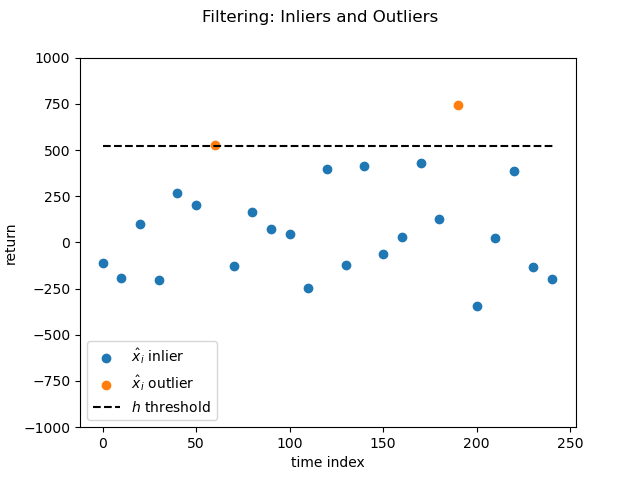

In [8]:
plt.figure()
plt.suptitle('Filtering: Inliers and Outliers')
plt.scatter(np.arange(n_m)[::m][inlier_idx_flt], x_mkt[::m][inlier_idx_flt], label='$\\hat x_i$ inlier')
plt.scatter(np.arange(n_m)[::m][outlier_idx_flt], x_mkt[::m][outlier_idx_flt], label='$\\hat x_i$ outlier')
plt.hlines(xmin=0,xmax=n_m,y=h, linestyle='--', label='$h$ threshold', color='k')
plt.xlabel('time index')
plt.ylabel('return')
plt.gca().set_ylim([-1000,1000])
plt.legend(loc='lower left')
plt.show()

The hypothesis test can then be run as usual:

In [9]:
# calculate exceedences T
t_mkt_flt = np.sum(outlier_idx_flt)

# calculate distribution of T under the null hypothesis
tdist_flt = ss.binom(n // m, 1-gamma)

# calculate the critical quantile
tcrit_flt = tdist_flt.ppf(1-alpha)

# calculate p-value
p_filtered = 1 - tdist_flt.cdf(t_mkt_flt)

In [10]:
print(f"Test score T of sample: {t_mkt_flt}")
print(f"Critical score: {tcrit_flt:.0f}")
print(f"p-value: {p_filtered * 100:.0f}%")
print(f"H0: {'rejected' if p_filtered < alpha else 'retained'}")

Test score T of sample: 2
Critical score: 3
p-value: 13%
H0: retained


## Correlated Null Distributions

While it is not easy to calculate the distribution of the test statistic on the full and correlated sample set analytically, we can certainly approximate it via Monte Carlo simulation. We simply have to generate realizations
\begin{align*}
    Y_i(\omega) \sim \mathcal{N}(0,\sigma^2_0), && i=1, \ldots, n, && \omega=1, \ldots, N
\end{align*}
of the vector $Y$ of daily samples, calculate realizations
\begin{align*}
    X_i(\omega) := \sum_{j=i}^{i+m-1}{Y_{j}(\omega)} \sim \mathcal{N}(0, m \sigma^2), && i=1, \ldots, n_m := 241,  && \omega=1, \ldots, N
\end{align*}
of the vector of $m$-day samples and use this to calculate realizations
\begin{align*}
    T(\omega) := \sum_{j=1}^{n_m} { 1_{ \{X_{j}(\omega) > h \} } }, &&  \omega=1, \ldots, N
\end{align*}
of the exceedence counter. These can then be used to obtain the critical test score
\begin{align*}
    t_{\operatorname{crit}}= Q_{1-\alpha}(T) 
\end{align*}
empirically.

In [11]:
inlier_idx_cor = x_mkt <= h
outlier_idx_cor = x_mkt > h

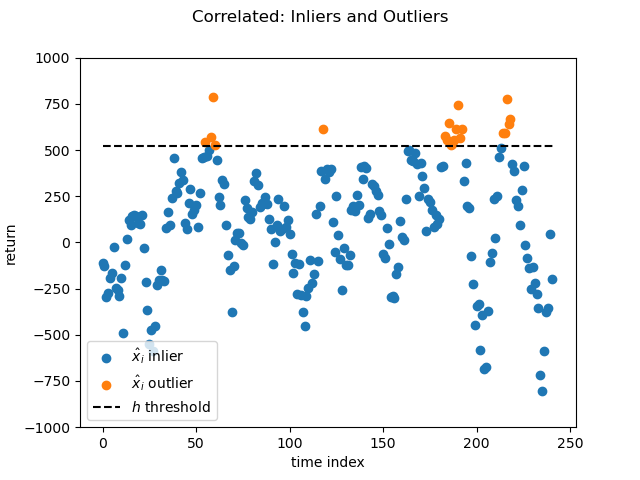

In [12]:
plt.figure()
plt.suptitle('Correlated: Inliers and Outliers')
plt.scatter(np.arange(n_m)[inlier_idx_cor], x_mkt[inlier_idx_cor], label='$\\hat x_i$ inlier')
plt.scatter(np.arange(n_m)[outlier_idx_cor], x_mkt[outlier_idx_cor], label='$\\hat x_i$ outlier')
plt.hlines(xmin=0,xmax=n_m,y=h, linestyle='--', label='$h$ threshold', color='k')
plt.xlabel('time index')
plt.ylabel('return')
plt.gca().set_ylim([-1000,1000])
plt.legend(loc='lower left')
plt.show()

In [13]:
# calculate exceedences T
t_mkt_cor = np.sum(outlier_idx_cor)

# calculate distribution of T under the null hypothesis
N = 10000
np.random.seed(1)
ysim = np.random.normal(0, sigma0, (N, n))
xsim = np.array([A@y for y in ysim])
tsim = np.sum(xsim > h, axis=1)

# calculate the critical quantile
tcrit_cor = ss.scoreatpercentile(tsim, (1-alpha) * 100, interpolation_method='lower')

# calculate p-value
p_cor = 1 - np.sum(tsim <= t_mkt_cor) / N

In [14]:
print(f"Test score T of sample: {t_mkt_cor}")
print(f"Critical score: {tcrit_cor:.0f}")
print(f"p-value: {p_cor*100:.0f}%")
print(f"H0: {'rejected' if p_cor < alpha else 'retained'}")

Test score T of sample: 20
Critical score: 27
p-value: 14%
H0: retained


## Decorrelated
Finally, we introduce the decorrelation strategy. The idea of this approach is that we do not only know the fact that the $X_i$ are correlated, but we do know precisely how they are correlated under the null hypothesis: by definition, their covariance matrix is explicitly given by
\begin{align*}
    \Sigma := \mathbb{V}[X] 
    = \mathbb{V}[AY]
    = A\mathbb{V}[Y]A^\top
    = \sigma^2 AA^\top.
\end{align*}
Hence, their correlation matrix is given by
\begin{align*}
    C:= \operatorname{Cor}[X] = \frac{1}{m} AA^\top.
\end{align*}

We calculate the [Cholesky decomposition](https://en.wikipedia.org/wiki/Cholesky_decomposition) $C=LL^{\top}$ of the correlation matrix. Thus, $L$ has the property that it maps independent Gaussians to Gaussians with correlation matrix $C$. We can therefore use its inverse to compute the *decorrelated samples*
\begin{align*}
    \bar X := L^{-1}X,
\end{align*}
which are hence independent. Thus, the exceedence counter on the decorrelated samples 
\begin{align*}
    \bar T := \sum_{i=1}^{n-m+1}{1_{\{\bar X_i > h\}}}
\end{align*}
now has a Binomial distribution on the full sample set and we can calculate the quantile analytically. 

In [15]:
# calculate correlation matrix
C = A @ A.T / m

# calculate Cholesky root
L = np.linalg.cholesky(C)

# invert Cholesky root
L_inv = np.linalg.inv(L)

# apply decorrelation
x_mkt_decor = L_inv @ x_mkt

# calculate out/inlier
inlier_idx_dec = x_mkt_decor <= h
outlier_idx_dec = x_mkt_decor > h

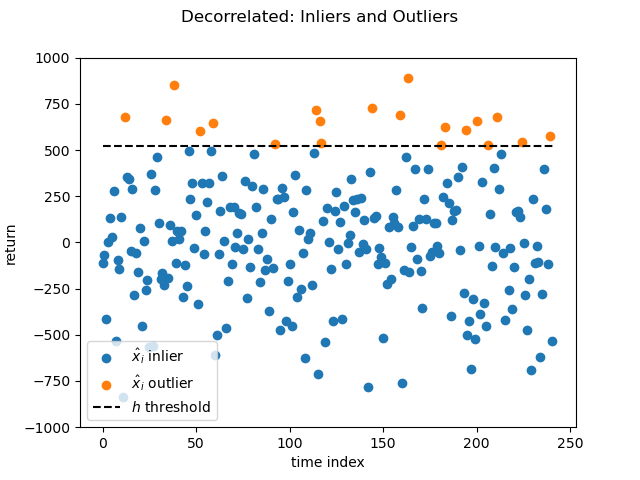

In [16]:
plt.figure()
plt.suptitle('Decorrelated: Inliers and Outliers')
plt.scatter(np.arange(n_m)[inlier_idx_dec], x_mkt_decor[inlier_idx_dec], label='$\\hat x_i$ inlier')
plt.scatter(np.arange(n_m)[outlier_idx_dec], x_mkt_decor[outlier_idx_dec], label='$\\hat x_i$ outlier')
plt.hlines(xmin=0,xmax=n_m,y=h, linestyle='--', label='$h$ threshold', color='k')
plt.xlabel('time index')
plt.ylabel('return')
plt.gca().set_ylim([-1000,1000])
plt.legend(loc='lower left')
plt.show()

In [17]:
# calculate exceedences T
t_mkt_decor = np.sum(outlier_idx_cor)

# calculate distribution of T under the null hypothesis
tdist_dec = ss.binom(n_m, 1-gamma)

# calculate the critical quantile
tcrit_dec = tdist_dec.ppf(1-alpha)

# calculate p-value
p_dec = 1 - tdist_dec.cdf(t_mkt_decor)

In [18]:
print(f"Test score T of sample: {t_mkt_decor}")
print(f"Critical score: {tcrit_dec:.0f}")
print(f"p-value: {p_dec * 100:.0f}%")
print(f"H0: {'rejected' if p_dec < alpha else 'retained'}")

Test score T of sample: 20
Critical score: 18
p-value: 1%
H0: rejected


### Remark: 10-day return vs 1-day returns
Notice that while the inverse Cholesky root $L^{-1}$ transforms the $m=10$-day samples $X$ to $\bar X$, which are independent, it is not true that $\bar X=Y$, i.e. it does just not map the $10$-day returns back to the daily returns (or some subset of them) as this is equivalent to saying that the Cholesky root $L$ is equal to the map $A$ that maps the daily returns to then $m=10$-day returns, which is not true. 

The precise relationship between the linear map $A \in \mathbb{R}^{n_m \times n}$ that maps the daily returns to the $m=10$-day returns, their correlation matrix $C \in \mathbb{R}^{n_m \times n_m}$ and its Cholesky root $L \in \mathbb{R}^{n_m}$ is
\begin{align*}
    C = \frac{1}{m}AA^{\top} = LL^{\top},
\end{align*}
but this does **not** imply that $L=\sqrt{m}A$. The matrix $A$ is not square, upper triangular and is not invertible. That is because while $A$ is surjective (which is evident as every $m=10$-day return can be written as a sum of daily returns), it is certainly not injective (as this representation is not unique). In fact $\dim \ker A = m - 1$. Conversely, the matrix $L$ is square, invertible and by construction a lower triangular matrix. 

We can also convice ourselves that the matrices $A$ and $\sqrt{m}L$ are distinct by just looking at them:

In [19]:
A

array([[1, 1, 1, ..., 0, 0, 0],
       [0, 1, 1, ..., 0, 0, 0],
       [0, 0, 1, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 1, 0, 0],
       [0, 0, 0, ..., 1, 1, 0],
       [0, 0, 0, ..., 1, 1, 1]])

In [20]:
np.sqrt(m) * L

array([[3.16227766, 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [2.84604989, 1.37840488, 0.        , ..., 0.        , 0.        ,
        0.        ],
       [2.52982213, 1.30585725, 1.3764944 , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 1.01851852, 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 1.01430976, 1.01850982,
        0.        ],
       [0.        , 0.        , 0.        , ..., 1.01010101, 1.01428364,
        1.01850105]])

### Remark: Independent vs Uncorrelated
In this model, the null distributions are Gaussian, for which the notions of beeing uncorrelated and beeing independent coindice. This might not hold in case the underlying distributions are more complicated.

# Power Analysis

We have shown three strategies on how to deal with correlations in a backtest. Which one is best? In the above example the filtering and the correlated method fail to detect the underestimation in the volatility, but the decorrelation does detect it. Is this a coincidence?

In order to systematically evaluate this, we first have to agree on a metric. We choose the [*discriminatory power*](https://en.wikipedia.org/wiki/Power_(statistics)) $G$, which intuitively is the probability to reject the null hypothesis under the assumption that the alternative is correct. Evidently this depends on the alternative. We use the alternative $H_1: \sigma > \sigma_0$, i.e. all centered normal distributions with a volatility greater than $\sigma_0$, the volatility of our null hypothesis. Formally, the power is defined by
\begin{align*}
    G:\Theta_1 \to \mathbb{R}, && \vartheta_1 \mapsto \mathbb{P}_{\vartheta_1}[\varphi=1]
    =\mathbb{P}_{\vartheta_1}[T>t_{\operatorname{crit}}] = 1 - \mathbb{P}_{\vartheta_1}[T \leq t_{\operatorname{crit}}].
\end{align*}
Notice that for our test $\Theta_1 = ]\sigma_1, \infty[$ and $\vartheta_1:=\sigma_1$. 

The power can always be calculated via Monte Carlo simulation as well, but for the filtering and the decorrelation, it is actually given analytically: Under $\mathbb{P}_{\vartheta_1}$, we have
\begin{align*}
    X_i \sim \mathcal{N}(0, m \sigma_1^2).
\end{align*}
The success probability, i.e. $\mathbb{P}_{\vartheta_1}[X_i > h]$, where $h=\sqrt{m} \sigma_0 \Phi^{-1}(\gamma)$, is given by
\begin{align*}
    p_1 
    := \mathbb{P}_{\vartheta_1}[X_i > h]
    = 1 - \mathbb{P}_{\vartheta_1}[X_i \leq h]
    = 1 - \Phi\Big(\Phi^{-1}(\gamma) \frac{\sigma_0}{\sigma_1}\Big)
\end{align*}
Together with the sample size, this determines the Binomail distribution of the alternative.

## Calculation

In [21]:
# specifying the alternatives
sigma1 = np.linspace(sigma0, 2 * sigma0, 11)

In [22]:
# generating alternative samples
N = 10000
np.random.seed(1)

# daily samples under alternative
y1 = np.array([np.random.normal(0, s1, (N, n)) for s1 in sigma1])

# m-day samples under alternative
x1 = np.array([[A @ yy for yy in yy1] for yy1 in y1])

In [23]:
# power of filtering calculated via monte carlo
t1_flt = np.sum(x1[:, :, ::m] > h, axis=-1)
g_flt_mc = 1 - np.sum(t1_flt <= tcrit_flt, axis=-1) / N

# power of filtering calculated analyticlly
p1 = 1 - ss.norm.cdf(sigma0 / sigma1 * ss.norm.ppf(gamma))
g_flt_ana = 1 - ss.binom.cdf(tcrit_flt, n // m, p1)

# power of correlated calculated via monte carlo
t1_cor = np.sum(x1 > h, axis=-1)
g_cor_mc = 1 - np.sum(t1_cor <= tcrit_cor, axis=-1) / N

# power of decorrelated calculated via monte carlo
x1_dec = np.array([[L_inv @ xx for xx in xx1] for xx1 in x1])
t1_dec = np.sum(x1_dec > h, axis=-1)
g_dec_mc = 1 - np.sum(t1_dec <= tcrit_dec, axis=-1) / N

# power of decorrelated calculated analytically
g_dec_ana = 1 - ss.binom.cdf(tcrit_dec, n_m, p1)

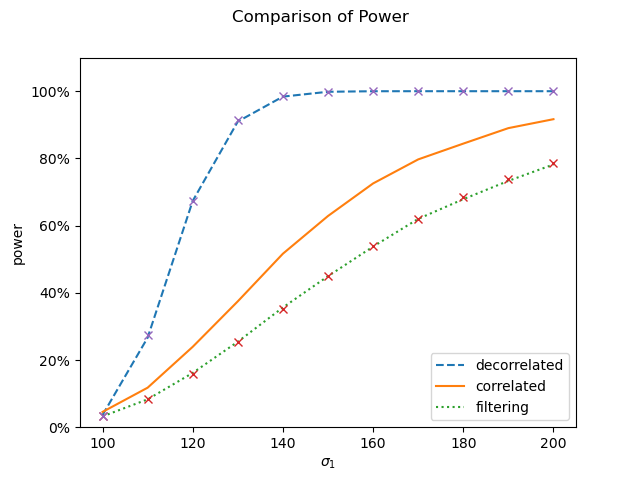

In [24]:
plt.figure()
plt.suptitle('Comparison of Power')
# plot power of test against alternatives calculated via Monte Carlo
plt.plot(sigma1, g_dec_mc * 100, label='decorrelated', linestyle='--')
plt.plot(sigma1, g_cor_mc * 100, label='correlated')
plt.plot(sigma1, g_flt_mc * 100, label='filtering', linestyle='dotted')
# plot power of test against alternatives calculated analytically (sanity check)
plt.plot(sigma1, g_flt_ana * 100, marker='x', linestyle='')
plt.plot(sigma1, g_dec_ana * 100, marker='x', linestyle='')
plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter())
plt.ylim([0, 110])
plt.xlabel(r"$\sigma_1$")
plt.ylabel('power')
plt.legend(loc='lower right')
plt.show()

We conclude that working the correlations of the full set of $241$ samples into the null distribution has uniformly higher power than the filtering, which only uses $25$ samples. This is intuitively plausible as the filtering simply has less data to detect the alternative. The decorrelated method has uniformly and significantly higher power than the correlated method. Both methods have the same number of $241$ samples and both methods account for the same correlation. This raises the question why the decorrelated method is so much more powerful?

## Explanation
An easy and intuitive way to explain the different power curves is to select one concrete alternative $\sigma_1$ and plot the PDFs of the test statistic $T$ under both, the null hypothesis and the alternative for all three correlation strategies. The hypothesis test answers the question: is the difference between those PDFs just due to random noise or are they systematically different? Let's take a look at the plots and see if we could answer this with the naked eye.

In [25]:
i1 = 1 # index of alternative

# some parameters for plotting
bwidth = 0.25
bins = np.linspace(1, 40, 41)

In [26]:
# histograms filtering
hist0_flt = np.histogram(t1_flt[0,:], bins=bins, density=False)[0]
hist1_flt = np.histogram(t1_flt[i1,:], bins=bins, density=False)[0]

# histograms correlated
hist0_cor = np.histogram(t1_cor[0,:], bins=bins, density=False)[0]
hist1_cor = np.histogram(t1_cor[i1,:], bins=bins, density=False)[0]

# histograms decorrelated
hist0_dec = np.histogram(t1_dec[0,:], bins=bins, density=False)[0]
hist1_dec = np.histogram(t1_dec[i1,:], bins=bins, density=False)[0]

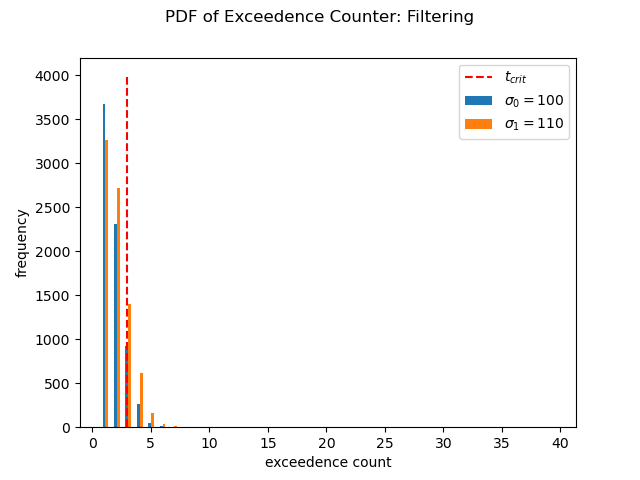

In [27]:
plt.figure()
plt.suptitle('PDF of Exceedence Counter: Filtering')
plt.bar(bins[:-1], hist0_flt, width=bwidth, label=f"$\\sigma_0=100$")
plt.bar(bins[:-1]+bwidth, hist1_flt, width=bwidth, label=f"$\\sigma_1={sigma1[i1]:.0f}$")
plt.vlines(tcrit_flt, ymin=0, ymax=4000, color='r', linestyle='--', label='$t_{crit}$')
plt.xlabel('exceedence count')
plt.ylabel('frequency')
plt.legend()
plt.show()

**Comment (filtering):** We can see that the filtering has access to only a small amount of data. Under the null hypothesis and the alternative, the test statistic has a Bionmial distribution and we can see the resulting "mountains", but not very well. The dashed line shows the critical quantile, so the power function integrates the alternative (orange) right of that, which in this case is not a lot and hence the power is low.

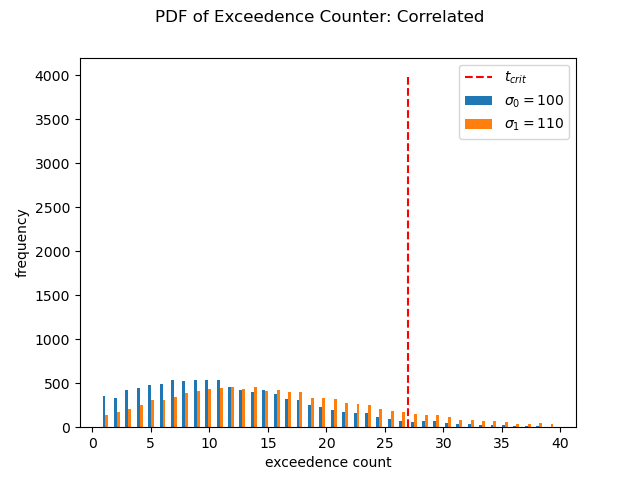

In [28]:
plt.figure()
plt.suptitle('PDF of Exceedence Counter: Correlated')
plt.bar(bins[:-1], hist0_cor, width=bwidth, label=f"$\\sigma_0=100$")
plt.bar(bins[:-1]+bwidth, hist1_cor, width=bwidth, label=f"$\\sigma_1={sigma1[i1]:.0f}$")
plt.vlines(tcrit_cor, ymin=0, ymax=4000, color='r', linestyle='--', label='$t_{crit}$')
plt.xlabel('exceedence count')
plt.ylabel('frequency')
plt.legend()
plt.show()

**Comment (correlated):** Here we can see the impact of working the correlations into the test statistic: The "mountains" now have much higher resolution and we can see with the naked eye that they are distinct. However, the "mountains" have also "melted", meaning the tail of these distributions in much longer. The power function only depends on the upper tail of the alternative down to the critical score of the null distribution. Because the null distribution has such a long tail (similar to the alternative) there is not much power to detect. This is a general drawback of the power function: In situations where the two distributions are quite distinct in the bulk, but similar in the tails, the power function will struggle to detect that distinction. 
Also note that the shape of the distributions on the correlated samples is completely different from the shape we obtain when the samples are independent, which is why ignoring this effect is absolutely not recommended.

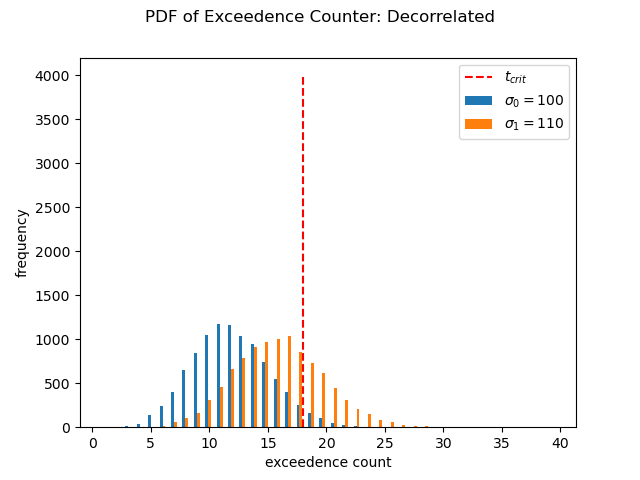

In [29]:
plt.figure()
plt.suptitle('PDF of Exceedence Counter: Decorrelated')
plt.bar(bins[:-1], hist0_dec, width=bwidth, label=f"$\\sigma_0=100$")
plt.bar(bins[:-1]+bwidth, hist1_dec, width=bwidth, label=f"$\\sigma_1={sigma1[i1]:.0f}$")
plt.vlines(tcrit_dec, ymin=0, ymax=4000, color='r', linestyle='--', label='$t_{crit}$')
plt.xlabel('exceedence count')
plt.ylabel('frequency')
plt.legend()
plt.show()

**Comment (decorrelated):** This plot looks like a classic hypothesis test. The null distribution and the alternatives are both nice Binomial mountains, they are clearly distinct to the naked eye and the power function has significant probability mass to detect.

# References

* **Peer-reviewed publication:** Nikolai Nowaczyk, Vladimir V. Piterbarg. *Backtesting Correlated Quantities*, [RISK.NET 09/2024](https://www.risk.net/cutting-edge/7959963/backtesting-correlated-quantities)

* **Pre-print:** Nikolai Nowaczyk, Vladimir V. Piterbarg. *Backtesting Correlated Quantities*. [SSRN 09/2023](https://ssrn.com/abstract=4571812)

* **Podcast:** Cesa, Maruo. *Podcast: Piterbarg and Nowaczyk on running better backtests* [Quantcast](https://www.risk.net/cutting-edge/views/7960227/podcast-piterbarg-and-nowaczyk-on-running-better-backtests)